In [1]:
!pip3 install torch torchvision torchaudio torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=bd6ee70b0d3dc5f8033ea2a1228ab03a6165af383a47eb3812b2d1dd0ef9a983
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [2]:
import os
import pickle
import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
import pandas as pd
import json
import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
import google.colab
from google.colab import files

In [3]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))])

# Download and load the training data
train_set_orig = datasets.FashionMNIST('MNIST_data/',
                                       download = True,
                                       train = True,
                                       transform = transform)
test_set_orig = datasets.FashionMNIST('MNIST_data/',
                                       download = True,
                                       train = False,
                                       transform = transform)

100%|██████████| 26.4M/26.4M [00:00<00:00, 119MB/s]


Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 51.2MB/s]

Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw




100%|██████████| 4.42M/4.42M [00:00<00:00, 66.5MB/s]


Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 2.69MB/s]


Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



##PARTE 1

In [4]:
class Autoencoder(nn.Module):
    """
    Combina el encoder, el linear_layer y el decoder en una sola red neuronal.
    """
    def __init__(self, n: int, p: float):
        """
        Constructor de la clase Autoencoder.

        Parámetros:
        - n (int): Número de neuronas en la capa lineal intermedia.
        """
        super(Autoencoder, self).__init__()
        # Codificador (Encoder)
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),  # Conv2d: (1, 28, 28) -> (16, 26, 26)
            nn.ReLU(),
            nn.Dropout(p=p),
            nn.MaxPool2d(kernel_size=2)  # MaxPool2d: (16, 26, 26) -> (16, 13, 13)
        )

        # Calcula el tamaño después del encoder
        self.encoder_output_shape = 16*13*13

        # Capas lineales con tamaño n
        self.linear_layer = nn.Sequential(
            nn.Flatten(),  # Aplana la entrada
            nn.Linear(self.encoder_output_shape, n),  # Reduce al tamaño n
            nn.ReLU(),                                #PREGUNTARRRRRRRR!!!!!
            nn.Dropout(p=p),                          #PREGUNTARRRRRRRR!!!!!
            nn.Linear(n, self.encoder_output_shape),  # Reconstruye al tamaño original
            nn.ReLU()
        )

        # Decodificador (Decoder)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=16,
                out_channels=1,
                kernel_size=6,
                stride=2,
                padding=1,
                output_padding=0
            ),  # ConvTranspose2d: (16, 13, 13) -> (1, 28, 28)
            nn.Sigmoid()  # Limita la salida al rango [0, 1]
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Define el flujo de datos a través de la red.

        Parámetros:
        - x (torch.Tensor): Tensor de entrada con forma (batch_size, 1, 28, 28).

        Retorno:
        - torch.Tensor: Tensor de salida con forma (batch_size, 1, 28, 28).
        """
        # Paso por el encoder
        encoded = self.encoder(x)

        # Paso por la capa lineal
        linear_output = self.linear_layer(encoded)

        # Reconstrucción: adaptamos el tensor para el decoder
        batch_size = x.size(0)
        decoded_input = linear_output.view(batch_size, 16, 13, 13)  # Volvemos al tamaño esperado por el decoder

        # Paso por el decoder
        decoded = self.decoder(decoded_input)
        return decoded


##PARTE 2

In [5]:
def train_error(model, train_loader, criterion, device):
    """
    Calcula la pérdida promedio en el conjunto de entrenamiento sin realizar backpropagation.

    Parámetros:
    - model: Modelo a evaluar.
    - train_loader: DataLoader para el conjunto de entrenamiento.
    - criterion: Función de pérdida.
    - device: Dispositivo (CPU o GPU) donde se ejecutará el modelo.

    Retorno:
    - avg_loss (float): Pérdida promedio en el conjunto de entrenamiento.
    """
    model.eval()  # Poner la red en modo de evaluación
    total_loss = 0

    with torch.no_grad():  # Desactivar el cálculo de gradientes
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)  # Paso hacia adelante
            loss = criterion(output, target)  # Calcular la pérdida
            total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    return avg_loss


def train_loop(model, train_loader, criterion, optimizer, device):
    """
    Realiza un ciclo de entrenamiento sobre el conjunto de datos.

    Parámetros:
    - model: Modelo a entrenar.
    - train_loader: DataLoader para el conjunto de entrenamiento.
    - criterion: Función de pérdida.
    - optimizer: Optimizador para actualizar los parámetros del modelo.
    - device: Dispositivo (CPU o GPU) donde se ejecutará el modelo.

    Retorno:
    - avg_loss (float): Pérdida promedio en el conjunto de entrenamiento tras esta época.
    """
    model.train()  # Poner la red en modo de entrenamiento

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()  # Limpiar gradientes previos
        output = model(data)  # Paso hacia adelante
        loss = criterion(output, target)  # Calcular la pérdida
        loss.backward()  # Paso hacia atrás
        optimizer.step()  # Actualizar los parámetros

    avg_loss = train_error(model, train_loader, criterion, device)
    return avg_loss

def valid_loop(model, valid_loader, criterion, device):
    model.eval()  # Poner la red en modo de evaluación
    total_loss = 0
    correct = 0

    with torch.no_grad():  # Desactivar el cálculo de gradientes
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)  # Paso hacia adelante
            loss = criterion(output, target)  # Calcular la pérdida

            total_loss += loss.item()

    avg_loss = total_loss / len(valid_loader)

    return avg_loss

In [6]:
class CustomDataset(Dataset):
    """
    Clase personalizada derivada de torch.utils.data.Dataset para transformar el
    dataset FashionMNIST a un formato pensado para entrenar un autoencoder.

    En lugar de retornar (imagen, etiqueta), retorna (imagen, imagen).
    """
    def __init__(self, dataset: Dataset):
        """
        Constructor de la clase CustomDataset.

        Parámetros:
        - dataset (Dataset): Dataset base (por ejemplo, FashionMNIST) que se va a transformar.
        """
        self.dataset = dataset

    def __len__(self) -> int:
        """
        Retorna la cantidad de muestras en el dataset.

        Retorno:
        - int: Longitud del dataset.
        """
        return len(self.dataset)

    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Retorna la i-ésima muestra del dataset como un par (input, output),
        donde ambos son iguales a la i-ésima imagen.

        Parámetros:
        - index (int): Índice de la muestra.

        Retorno:
        - tuple[torch.Tensor, torch.Tensor]: Par (imagen, imagen).
        """
        image, _ = self.dataset[index]  # Ignorar el label original
        return image, image

In [7]:
# Transformar a datasets para autoencoder usando CustomDataset
train_set_autoencoder = CustomDataset(train_set_orig)
test_set_autoencoder = CustomDataset(test_set_orig)

#Haciendo los loaders
train_loader = DataLoader(dataset=train_set_autoencoder, batch_size=100, shuffle=True)
valid_loader = DataLoader(dataset=test_set_autoencoder, batch_size=100, shuffle=True)

In [12]:
# Crear el modelo
n = 200
model = Autoencoder(n=n, p=0.2)

In [13]:
# Definir la función de pérdida
criterion = nn.MSELoss()

learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Modelo trabajando en: {device}")

Modelo trabajando en: cpu


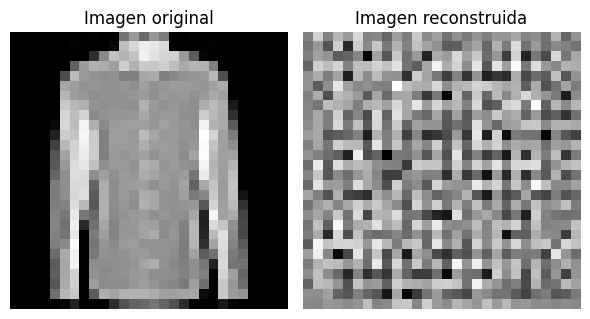

In [14]:
import random

random_idx = random.randint(0, len(train_set_orig) - 1)  # Índice aleatorio
image = train_set_orig[random_idx][0]  # Imagen original
image_with_channel = image.unsqueeze(0)  # Agregar el canal para pasarlo al modelo

output_tensor = model(image_with_channel)
output_image = output_tensor.detach().squeeze(0)  # Salida reconstruida

fig, axes = plt.subplots(1, 2, figsize=(6, 4))


axes[0].imshow(image.squeeze(), cmap="Greys_r")
axes[0].axis("off")
axes[0].set_title("Imagen original")

# Imagen reconstruida
axes[1].imshow(output_image[0], cmap="Greys_r")  # Seleccionar canal 0
axes[1].axis("off")
axes[1].set_title("Imagen reconstruida")

plt.tight_layout()
plt.show()

In [15]:
num_epochs = 5
train_losses = []
valid_losses = []

for epoch in range(1, num_epochs + 1):
    print(f"\nÉpoca {epoch}/{num_epochs}")

    # Entrenamiento
    train_loss = train_loop(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    # Validación
    valid_loss = valid_loop(model, valid_loader, criterion, device)
    valid_losses.append(valid_loss)


    print(f"Resumen - Época {epoch}:")
    print(f"  Pérdida de entrenamiento: {train_loss:.4f}")
    print(f"  Pérdida de validación: {valid_loss:.4f}")

print("\nEntrenamiento finalizado.")


Época 1/5
Resumen - Época 1:
  Pérdida de entrenamiento: 0.6023
  Pérdida de validación: 0.5999

Época 2/5
Resumen - Época 2:
  Pérdida de entrenamiento: 0.5962
  Pérdida de validación: 0.5939

Época 3/5
Resumen - Época 3:
  Pérdida de entrenamiento: 0.5932
  Pérdida de validación: 0.5909

Época 4/5
Resumen - Época 4:
  Pérdida de entrenamiento: 0.5913
  Pérdida de validación: 0.5890

Época 5/5
Resumen - Época 5:
  Pérdida de entrenamiento: 0.5900
  Pérdida de validación: 0.5877

Entrenamiento finalizado.


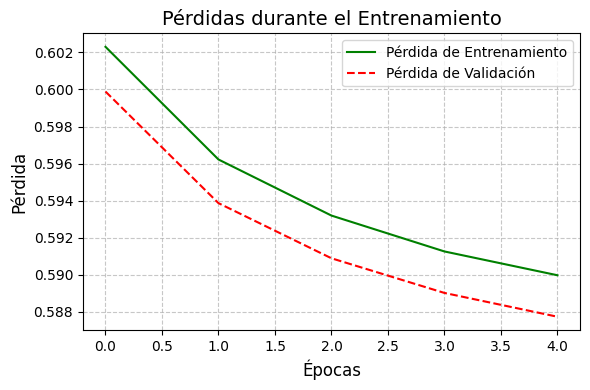

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Gráfico de pérdidas (Train vs Validation)
ax.plot(train_losses, label='Pérdida de Entrenamiento', color='green', linestyle='-')
ax.plot(valid_losses, label='Pérdida de Validación', color='red', linestyle='--')
ax.set_title('Pérdidas durante el Entrenamiento', fontsize=14)
ax.set_xlabel('Épocas', fontsize=12)
ax.set_ylabel('Pérdida', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

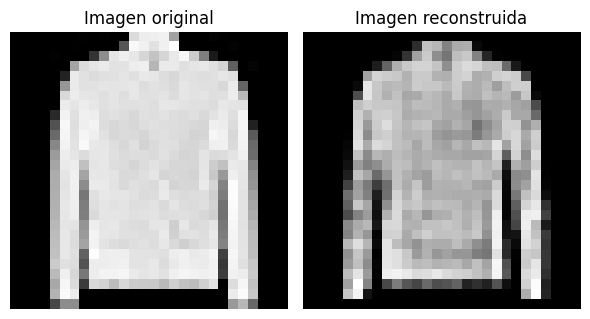

In [27]:
import random

random_idx = random.randint(0, len(train_set_orig) - 1)  # Índice aleatorio
image = train_set_orig[random_idx][0]  # Imagen original
image_with_channel = image.unsqueeze(0)  # Agregar el canal para pasarlo al modelo

output_tensor = model(image_with_channel)
output_image = output_tensor.detach().squeeze(0)  # Salida reconstruida

fig, axes = plt.subplots(1, 2, figsize=(6, 4))


axes[0].imshow(image.squeeze(), cmap="Greys_r")
axes[0].axis("off")
axes[0].set_title("Imagen original")

# Imagen reconstruida
axes[1].imshow(output_image[0], cmap="Greys_r")  # Seleccionar canal 0
axes[1].axis("off")
axes[1].set_title("Imagen reconstruida")

plt.tight_layout()
plt.show()

##PARTE 3

In [17]:
class Classifier(nn.Module):
    """
    Clasificador basado en el encoder del autoencoder preentrenado.
    """
    def __init__(self, encoder: nn.Module, encoder_output_shape: int,  num_classes: int):
        """
        Constructor del clasificador.

        Parámetros:
        - encoder (nn.Module): Encoder preentrenado del autoencoder.
        - num_classes (int): Número de clases para la clasificación.
        """
        super(Classifier, self).__init__()
        self.encoder = encoder  # Reutilizamos el encoder preentrenado

        # Capa de clasificación
        self.classifier = nn.Sequential(
            nn.Flatten(),  # Aplana la salida del encoder
            nn.Linear(encoder_output_shape, 128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Define el flujo de datos para la clasificación.

        Parámetros:
        - x (torch.Tensor): Tensor de entrada con forma (batch_size, 1, 28, 28).

        Retorno:
        - torch.Tensor: Probabilidades de las clases (sin aplicar softmax).
        """
        # Paso por el encoder preentrenado
        features = self.encoder(x)

        # Paso por la capa de clasificación
        logits = self.classifier(features)

        return logits


In [18]:
# Reutilizar el encoder preentrenado
pretrained_encoder = model.encoder

# Crear el clasificador
classifier = Classifier(encoder=pretrained_encoder, encoder_output_shape=model.encoder_output_shape, num_classes=10)

In [19]:
def train_error_classification(model, train_loader, criterion, device):
  model.eval()  # Poner la red en modo de evaluación
  total_loss = 0
  correct = 0

  with torch.no_grad():  # Desactivar el cálculo de gradientes
      for batch_idx, (data, target) in enumerate(train_loader):
          data, target = data.to(device), target.to(device)

          output = model(data)  # Paso hacia adelante
          loss = criterion(output, target)  # Calcular la pérdida

          total_loss += loss.item()
          pred = output.argmax(dim=1, keepdim=True)  # Obtener predicciones
          correct += pred.eq(target.view_as(pred)).sum().item()

  avg_loss = total_loss / len(train_loader)
  accuracy = 100. * correct / len(train_loader.dataset)

  return avg_loss, accuracy


def train_loop_classification(model, train_loader, criterion, optimizer, device):
    model.train()  # Poner la red en modo de entrenamiento

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()  # Limpiar gradientes previos
        output = model(data)  # Paso hacia adelante
        loss = criterion(output, target)  # Calcular la pérdida
        loss.backward()  # Paso hacia atrás
        optimizer.step()  # Actualizar los parámetros

    avg_loss, accuracy = train_error_classification(model, train_loader, criterion, device)
    return avg_loss, accuracy

def valid_loop_classification(model, valid_loader, criterion, device):
    model.eval()  # Poner la red en modo de evaluación
    total_loss = 0
    correct = 0

    with torch.no_grad():  # Desactivar el cálculo de gradientes
        for batch_idx, (data, target) in enumerate(valid_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)  # Paso hacia adelante
            loss = criterion(output, target)  # Calcular la pérdida

            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)  # Obtener predicciones
            correct += pred.eq(target.view_as(pred)).sum().item()

    avg_loss = total_loss / len(valid_loader)
    accuracy = 100. * correct / len(valid_loader.dataset)

    return avg_loss, accuracy

In [20]:
train_loader_classification = DataLoader(dataset=train_set_orig, batch_size=100, shuffle=True)
valid_loader_classification = DataLoader(dataset=test_set_orig, batch_size=100, shuffle=True)

In [21]:
# Definir la función de pérdida
criterion = nn.CrossEntropyLoss()

learning_rate = 1e-3
optimizer = optim.SGD(classifier.parameters(), lr=learning_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier.to(device)
print(f"Modelo trabajando en: {device}")

Modelo trabajando en: cpu


In [22]:
num_epochs = 5
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

for epoch in range(1, num_epochs + 1):
    print(f"\nÉpoca {epoch}/{num_epochs}")

    # Entrenamiento
    train_loss, train_accuracy = train_loop_classification(classifier, train_loader_classification, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validación
    valid_loss, valid_accuracy = valid_loop_classification(classifier, valid_loader_classification, criterion, device)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

    print(f"Resumen - Época {epoch}:")
    print(f"  Pérdida de entrenamiento: {train_loss:.4f}")
    print(f"  Pérdida de validación: {valid_loss:.4f}, Precisión de validación: {valid_accuracy:.2f}%")

print("\nEntrenamiento finalizado.")


Época 1/5
Resumen - Época 1:
  Pérdida de entrenamiento: 1.4490
  Pérdida de validación: 1.4540, Precisión de validación: 68.08%

Época 2/5
Resumen - Época 2:
  Pérdida de entrenamiento: 1.0239
  Pérdida de validación: 1.0315, Precisión de validación: 72.19%

Época 3/5
Resumen - Época 3:
  Pérdida de entrenamiento: 0.8457
  Pérdida de validación: 0.8549, Precisión de validación: 74.80%

Época 4/5
Resumen - Época 4:
  Pérdida de entrenamiento: 0.7504
  Pérdida de validación: 0.7612, Precisión de validación: 76.52%

Época 5/5
Resumen - Época 5:
  Pérdida de entrenamiento: 0.6890
  Pérdida de validación: 0.7007, Precisión de validación: 77.81%

Entrenamiento finalizado.


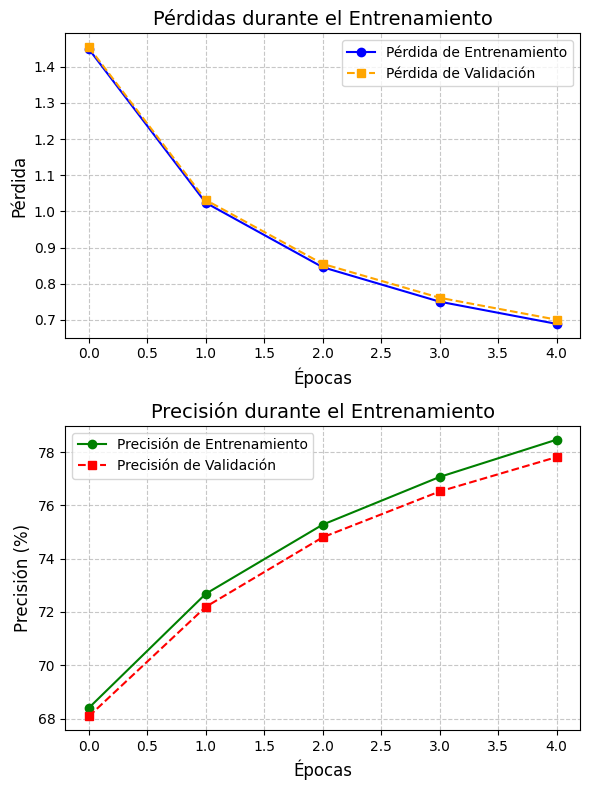

In [23]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

# Gráfico de pérdidas (Train vs Validation)
ax[0].plot(train_losses, label='Pérdida de Entrenamiento', color='blue', linestyle='-', marker='o')
ax[0].plot(valid_losses, label='Pérdida de Validación', color='orange', linestyle='--', marker='s')
ax[0].set_title('Pérdidas durante el Entrenamiento', fontsize=14)
ax[0].set_xlabel('Épocas', fontsize=12)
ax[0].set_ylabel('Pérdida', fontsize=12)
ax[0].legend(fontsize=10)
ax[0].grid(True, linestyle='--', alpha=0.7)

# Gráfico de precisiones (Train vs Validation)
ax[1].plot(train_accuracies, label='Precisión de Entrenamiento', color='green', linestyle='-', marker='o')
ax[1].plot(valid_accuracies, label='Precisión de Validación', color='red', linestyle='--', marker='s')

ax[1].set_title('Precisión durante el Entrenamiento', fontsize=14)
ax[1].set_xlabel('Épocas', fontsize=12)
ax[1].set_ylabel('Precisión (%)', fontsize=12)
ax[1].legend(fontsize=10)
ax[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

##PARTE 4

In [28]:
# Congelar los parámetros del codificador
for param in classifier.encoder.parameters():
    param.requires_grad = False

criterion = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = optim.SGD(classifier.parameters(), lr=learning_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier.to(device)
print(f"Modelo trabajando en: {device}")

Modelo trabajando en: cpu


In [29]:
num_epochs = 5
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

for epoch in range(1, num_epochs + 1):
    print(f"\nÉpoca {epoch}/{num_epochs}")

    # Entrenamiento
    train_loss, train_accuracy = train_loop_classification(classifier, train_loader_classification, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validación
    valid_loss, valid_accuracy = valid_loop_classification(classifier, valid_loader_classification, criterion, device)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

    print(f"Resumen - Época {epoch}:")
    print(f"  Pérdida de entrenamiento: {train_loss:.4f}")
    print(f"  Pérdida de validación: {valid_loss:.4f}, Precisión de validación: {valid_accuracy:.2f}%")

print("\nEntrenamiento finalizado.")


Época 1/5
Resumen - Época 1:
  Pérdida de entrenamiento: 0.6544
  Pérdida de validación: 0.6665, Precisión de validación: 78.84%

Época 2/5
Resumen - Época 2:
  Pérdida de entrenamiento: 0.6271
  Pérdida de validación: 0.6403, Precisión de validación: 79.76%

Época 3/5
Resumen - Época 3:
  Pérdida de entrenamiento: 0.6054
  Pérdida de validación: 0.6189, Precisión de validación: 80.34%

Época 4/5
Resumen - Época 4:
  Pérdida de entrenamiento: 0.5856
  Pérdida de validación: 0.5997, Precisión de validación: 80.75%

Época 5/5
Resumen - Época 5:
  Pérdida de entrenamiento: 0.5694
  Pérdida de validación: 0.5842, Precisión de validación: 81.21%

Entrenamiento finalizado.


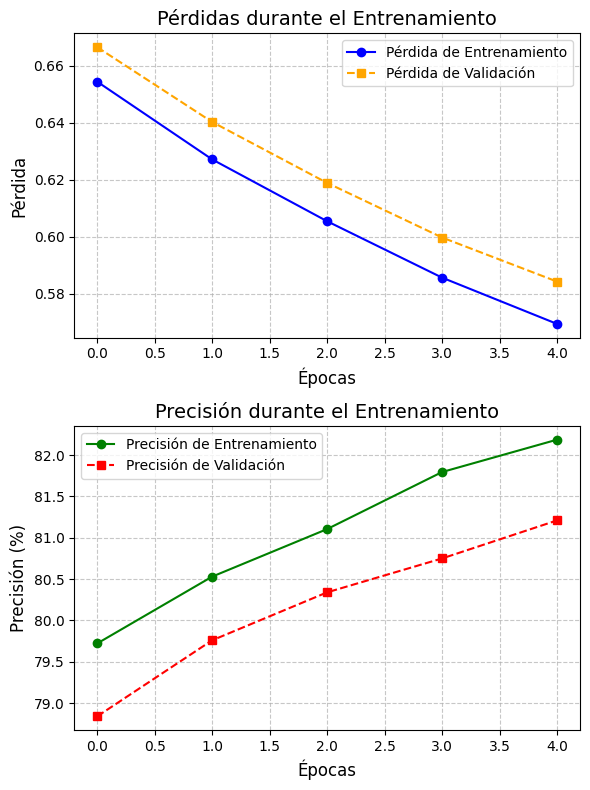

In [30]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

# Gráfico de pérdidas (Train vs Validation)
ax[0].plot(train_losses, label='Pérdida de Entrenamiento', color='blue', linestyle='-', marker='o')
ax[0].plot(valid_losses, label='Pérdida de Validación', color='orange', linestyle='--', marker='s')
ax[0].set_title('Pérdidas durante el Entrenamiento', fontsize=14)
ax[0].set_xlabel('Épocas', fontsize=12)
ax[0].set_ylabel('Pérdida', fontsize=12)
ax[0].legend(fontsize=10)
ax[0].grid(True, linestyle='--', alpha=0.7)

# Gráfico de precisiones (Train vs Validation)
ax[1].plot(train_accuracies, label='Precisión de Entrenamiento', color='green', linestyle='-', marker='o')
ax[1].plot(valid_accuracies, label='Precisión de Validación', color='red', linestyle='--', marker='s')

ax[1].set_title('Precisión durante el Entrenamiento', fontsize=14)
ax[1].set_xlabel('Épocas', fontsize=12)
ax[1].set_ylabel('Precisión (%)', fontsize=12)
ax[1].legend(fontsize=10)
ax[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()